In [31]:
import os
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model

In [32]:
def DrawPics(tensor,nb=0,template='{}',classnumber=None):
    if (nb==0):
        N = tensor.shape[0]
    else:
        N = min(nb,tensor.shape[0])
    fig=plt.figure(figsize=(16,2))
    nbligne = floor(N/20)+1
    for m in range(N):
        subplot = fig.add_subplot(nbligne,min(N,20),m+1)
        axis("off")
        plt.imshow(tensor[m,:,:,0],vmin=0, vmax=1,cmap='Greys')
        if (classnumber!=None):
            subplot.title.set_text((template.format(classnumber)))

In [33]:
model_path = './weights/'

### Generation des images


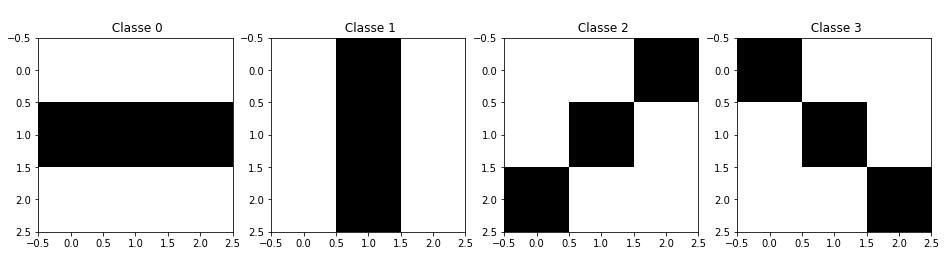

In [34]:
#Generation des 4 images de base => (4,3,3,1)
basepicture =np.zeros((4,3,3,1))
for m in range(4):
    if (m==0):
        #Horizontale        
        for j in range(3):
            basepicture[m,1,j,0] = 1
    if (m==1):
        #Vertical
        for j in range(3):
            basepicture[m,j,1,0] = 1
    if (m==2):
        #Diag
        for j in range(3):
            basepicture[m,2-j,j,0] = 1
    if (m==3):
        #Backslash
        for j in range(3):
            basepicture[m,j,j,0] = 1

basepictureH = basepicture[0,:,:,0]
basepictureV = basepicture[1,:,:,0]
basepictureD = basepicture[2,:,:,0]
basepictureB = basepicture[3,:,:,0]
fig=plt.figure(figsize=(16,16))
template=('\n Classe {}')
for classe in range(4):
    subplot = fig.add_subplot(1,4,classe+1)
    plt.imshow(basepicture[classe,:,:,0],vmin=0, vmax=1,cmap='Greys')
    subplot.title.set_text((template.format(classe)))





## Generation dataset

In [35]:
def buildDataSet(basepicture, nb_image_per_class=1, noise_amplitude=0.2):
    """Generation d'image en rajoutant du bruit sur les images de base
    
    
    returns:
        dataset : tableau (N) contenant les images pour chacune des classes (nb_image_per_class,3,3,1)
    """
    N,w,h,c = basepicture.shape
    
    SplitTrainTest = 0.7
    nb_train_sample = int(nb_image_per_class*SplitTrainTest)
    nb_test_sample = nb_image_per_class-nb_train_sample
    
    dataset_train = [np.zeros((nb_train_sample,h, w,c)) for i in range(N)]
    dataset_test = [np.zeros((nb_test_sample,h, w,c)) for i in range(N)]
    
    for n in range(N):
        #Genere la matrice de bruit pour toutes les images
        dataset_train[n] = np.random.uniform(0,noise_amplitude,(nb_train_sample,w,h,c))
        dataset_test[n] = np.random.uniform(0,noise_amplitude,(nb_test_sample,w,h,c))
        
        #Ajoute l'image de base au bruit existant
        for x in range(nb_train_sample):
            dataset_train[n][x,:,:,0] += basepicture[n,:,:,0]
            
        for x in range(nb_test_sample):
            dataset_test[n][x,:,:,0] += basepicture[n,:,:,0]
            
        #Clip les valeurs en dehors de 0 1
        dataset_train[n] = np.clip(dataset_train[n],0,1)
        dataset_test[n] = np.clip(dataset_test[n],0,1)
        
    return dataset_train,dataset_test

(700, 3, 3, 1)
(300, 3, 3, 1)
dataset train : 4x (700, 3, 3, 1)
dataset test : 4x (300, 3, 3, 1)


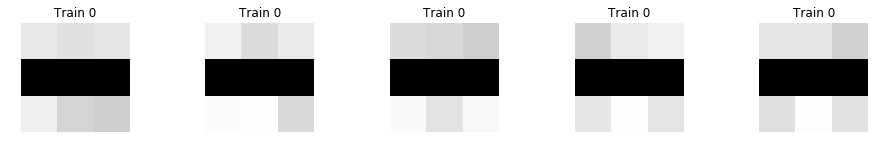

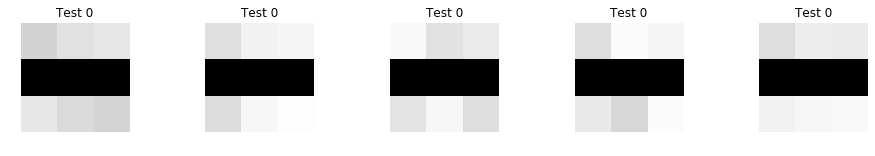

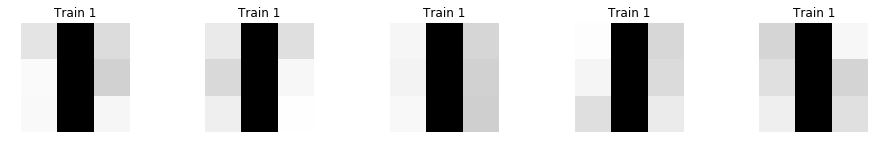

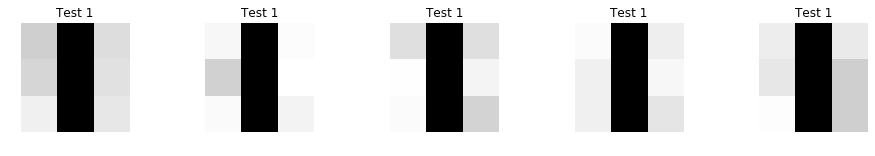

In [36]:
dataset_train,dataset_test = buildDataSet(basepicture, nb_image_per_class=1000, noise_amplitude=0.3)
print(dataset_train[0].shape)
print(dataset_test[0].shape)
print("dataset train : 4x",dataset_train[0].shape)
print("dataset test : 4x",dataset_test[0].shape)
for i in range(2):
    DrawPics(dataset_train[i],5,template='Train {}',classnumber=i)
    DrawPics(dataset_test[i],5,template='Test {}',classnumber=i)


### Definition du modele de similarité

In [37]:
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [38]:
def build_model(input_shape):
     # Define the tensors for the two input images
    left_input = Input(input_shape, name="left_input")
    right_input = Input(input_shape, name="right_input")
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (3,3), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    
    model.add(Flatten())
    model.add(Dense(30, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [78]:
siameseModel = build_model((3,3,1))
siameseModel.summary()
plot_model(siameseModel,show_shapes=True, show_layer_names=True)
optimizer = Adam(lr = 0.00006)
siameseModel.compile(loss="binary_crossentropy",optimizer=optimizer)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        (None, 3, 3, 1)      0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 30)           2590        left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 30)           0           sequential_6[1][0]               
          

In [40]:
testinput = [np.zeros((1,3,3,1)) for i in range(2)]
testinput[0][0,:,:,:] = basepicture[0,:,:,:]
testinput[1][0,:,:,:] = basepicture[2,:,:,:]
probs = siameseModel.predict(testinput)
print(probs)

[[0.62528515]]


### Train

In [41]:
def get_batch(batch_size,s="train"):
    """
    Create batch of n pairs, half same class, half different class
    
    Arguments:
    batch_size -- integer 

    Returns:
    pairs -- tableau (2,batchsize) contenant les 2 images left,right de shape (batch_size,w,h,c)
    targets -- tableau (2,batchsize) contenant les labels des images left et right 
    """
    if s == 'train':
        X = dataset_train
    else:
        X = dataset_test
    m, w, h,c = X[0].shape
    
    # randomly sample several classes to use in the batch
    n_classes = len(dataset_train)
    categories = np.random.choice(n_classes,size=(batch_size,),replace=True)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,c)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # La premiere moitie du batch sont des paires de memes classes (=1), la deuxieme moitié differentes (=0)
    targets[:batch_size//2] = 1
    
    for i in range(batch_size):
        category = categories[i] #classe
        
        #une image au hasard de cette classe
        idx_1 = np.random.randint(0, m) 
        pairs[0][i,:,:,:] = X[category][idx_1,:,:,:]
        
        # pick images of same class for 1st half, different for 2nd
        if i < batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        idx_2 = np.random.randint(0, m)
        pairs[1][i,:,:,:] = X[category_2][idx_2,:,:,:]
    
    return pairs, targets

In [42]:
def generate(batch_size, s="train"):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size,s)
        yield (pairs, targets)

(3, 3, 3, 1)
(3,)
[1. 0. 0.]


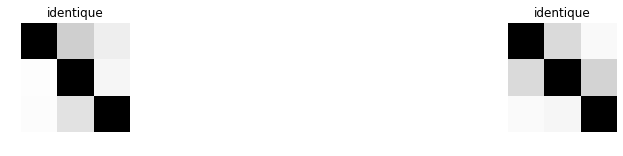

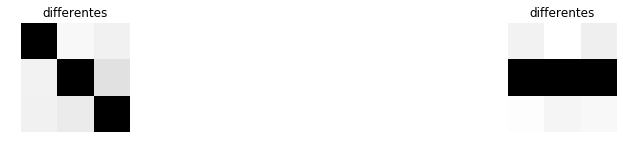

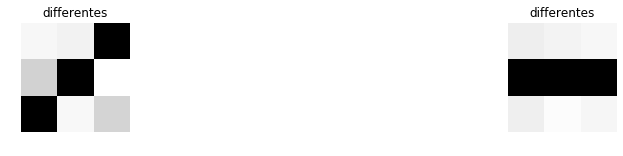

In [43]:
pairs, targets = get_batch(3)
print(pairs[0].shape)
print(targets.shape)
print(targets)

for i in range(pairs[0].shape[0]):
    tab = np.zeros((2,3,3,1))
    #image left
    tab[0,:,:,:] = pairs[0][i,:,:,:]
    #image right
    tab[1,:,:,:] = pairs[1][i,:,:,:]
    
    if(targets[i]==0):
        DrawPics(tab,classnumber="differentes")
    else:
        DrawPics(tab,classnumber="identique")

In [75]:
# Hyper parameters
evaluate_every = 5 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
best = -1

### Validation
(Version simplifiée)
On veut evaluer une image de test vs toutes les images de base. Si le meilleur score de l'evaluation est sur la bonne classe => resultat bon sinon on considere que c'est faux



In [45]:
def evaluation(model, nbimage_test_per_class):
    '''
    Evalue le modele avec des images de test
    
    Returns
        scores : resultat des scores de similarités avec les images de base => (nbimage_test,N,N)
        accuracy : accuracy
    '''
    N=4
    _, w,h,c = dataset_test[0].shape
    scores = np.zeros((nbimage_test_per_class,N,N))
    n_correct = 0
    for i in range(nbimage_test_per_class):
        #On teste toutes les categories a la fois
        for n in range(4):
            #Choisi une image pour cette classe n
            idx = np.random.randint(0, dataset_test[n].shape[0]) 
            
            #genere les 4 jeux de test : cette image vs les 4 images de base
            input = [np.zeros((4,w,h,c)) for x in range(2)]
            for n2 in range(4):
                #image de test
                input[0][n2,:,:,:] = dataset_test[n][idx,:,:,:]
                #image de ref
                input[1][n2,:,:,:] = basepicture[n2,:,:,:]
                
            #fait la prediction des 4 paires avec notre Net
            probs = model.predict(input)
            scores[i,n,:] = probs[:,0]
            if (np.argmax(probs) == n):
                n_correct += 1
                
    accuracy = (100.0 * n_correct / nbimage_test_per_class / N)
    return scores,accuracy
    

In [80]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter+1):
    (inputs,targets) = get_batch(batch_size)
    loss = siameseModel.train_on_batch(inputs, targets)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        scores,val_acc = evaluation(siameseModel, n_val)
        print("Test accuracy: {0}".format(val_acc))
        siameseModel.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        if val_acc > best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            best = val_acc

Starting training process!
-------------------------------------

 ------------- 

Time for 5 iterations: 0.04410914182662964 mins
Train Loss: 0.7226119041442871
Test accuracy: 100.0

 ------------- 

Time for 10 iterations: 0.08398869832356771 mins
Train Loss: 0.7225458025932312
Test accuracy: 100.0

 ------------- 

Time for 15 iterations: 0.12353190183639526 mins
Train Loss: 0.7224474549293518
Test accuracy: 100.0

 ------------- 

Time for 20 iterations: 0.15881349245707194 mins
Train Loss: 0.7223678827285767
Test accuracy: 100.0


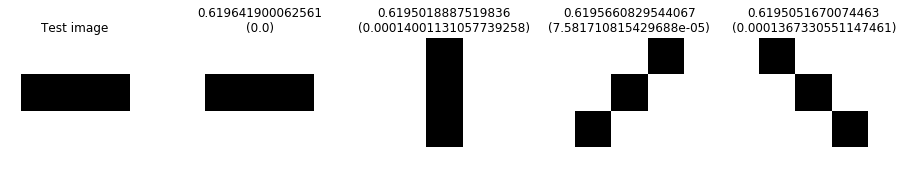

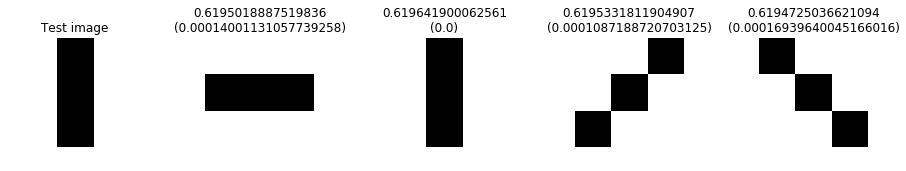

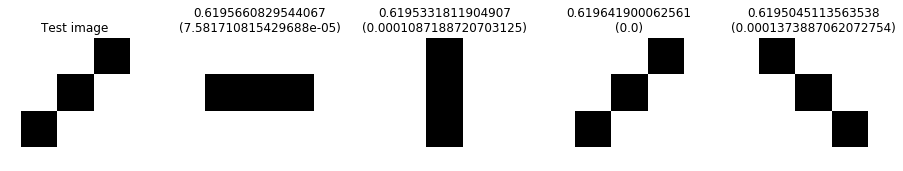

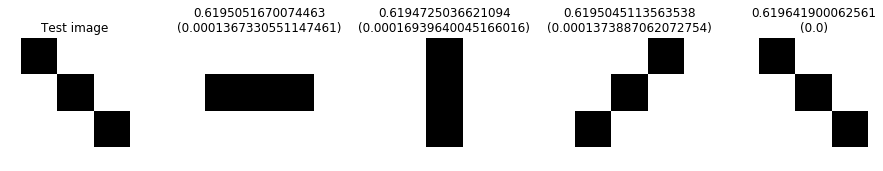

In [79]:
#Test du modele entrainé
def drawEvaluation(model,image):
    #genere les 4 jeux de test : cette image vs les 4 images de base
    w,h,c = image.shape
    input = [np.zeros((4,w,h,c)) for x in range(2)]
    for n2 in range(4):
        #image de test
        input[0][n2,:,:,:] = image
        #image de ref
        input[1][n2,:,:,:] = basepicture[n2,:,:,:]
                
    #fait la prediction des 4 paires avec notre Net
    probs = model.predict(input)
    
    #Prepare la figure pour comparer
    fig=plt.figure(figsize=(16,2))
    subplot = fig.add_subplot(1,5,1)
    axis("off")
    plt.imshow(image[:,:,0],vmin=0, vmax=1,cmap='Greys')
    subplot.title.set_text("Test image")
    maxprob = np.max(probs)
    for n in range(4):
        subplot = fig.add_subplot(1,5,n+2)
        axis("off")
        plt.imshow(basepicture[n,:,:,0],vmin=0, vmax=1,cmap='Greys')
        subplot.title.set_text(("{1}\n({2})".format(n,probs[n,0],maxprob-probs[n,0])))
        
def DrawTestImage(model,classe,number):
    drawEvaluation(model,dataset_test[classe][number,:,:,:])

def drawOriginEvaluation(model):
    for n in range(4):
        drawEvaluation(model,basepicture[n,:,:,:])
        
drawOriginEvaluation(siameseModel)

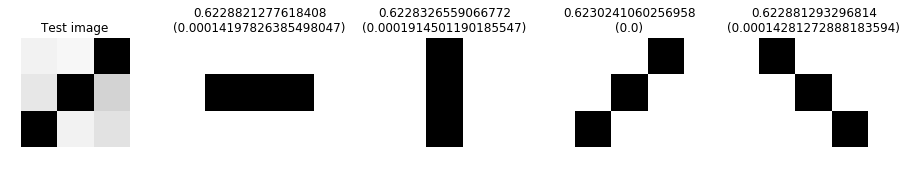

In [77]:
DrawTestImage(siameseModel,classe=2,number=1)
